In [1]:
import os
import pickle
from tqdm import tqdm
import sentencepiece as spm

In [2]:
source_folder = '/scratche/home/apoorv/repos/probe_kge/data/wnrr'
! ls {source_folder}

dataset.yaml	    test.txt		     valid.del
entity_ids.del	    test_without_unseen.del  valid.txt
entity_strings.del  train.del		     valid_without_unseen.del
relation_ids.del    train_sample.del
test.del	    train.txt


In [3]:
def readTriples(fname):
    f = open(fname)
    triples = []
    for line in f:
        if line[-1] == '\n':
            line = line[:-1]
        triples.append(line.split('\t'))
    f.close()
    return triples

In [4]:
data = {}
splits = ['train', 'test', 'valid']
for split in splits:
    fname = os.path.join(source_folder, split + '.txt')
    data[split] = readTriples(fname)

In [5]:
data['train'][5000]

['09429387', '_hypernym', '09385911']

In [6]:
len(data['train'])

86835

In [7]:
uniq_tails = set()
for t in data['train']:
    uniq_tails.add(t[2])
len(uniq_tails)

31881

In [9]:
def getPOS(name):
    return name[2:].split('_')[-2]

def processDefinition(definition):
    if '\"' in definition and ':' in definition:
        out = definition.split(':')[0]
    if ';' in definition:
        out = definition.split(';')[0]
    else:
        out = definition
    return out

def getAlias(name, definition):
    pos = getPOS(name)
    name = ' '.join(name[2:].split('_')[:-2])
    definition = processDefinition(definition)
    out = name + ', ' + pos + ' -- ' + definition
    return out

In [23]:
dest_folder = '/scratche/home/apoorv/transformer-kgc/data/wnrr'
aliases_dict = {}
# fname = os.path.join(dest_folder, 'wn-entity2text-new.txt')
fname = os.path.join(dest_folder, 'wordnet-mlj12-definitions.txt')
ent_names = []
definitions = []
aliases_set = set()
f = open(fname)
for line in f:
    line = line.rstrip().split('\t')
    name = line[1][2:].replace('_', ' ')
    ent_names.append(name)
    alias = name
    if alias in aliases_set:
        print(line, alias)
        alias = alias + ' 2'
    else:
        aliases_set.add(alias)
    aliases_dict[line[0]] = alias
f.close()

In [24]:
len(aliases_dict), len(set(aliases_dict.values()))

(40943, 40943)

In [25]:
count = 0
for k, v in aliases_dict.items():
    print(v)
    count += 1
    if count == 100:
        break

stool NN 2
chieftainship NN 1
saxony NN 1
ondatra zibethica NN 1
founder VB 2
rose campion NN 1
enjoyment NN 1
german shepherd dog NN 1
quilt VB 1
wake island NN 1
raise VB 8
admiralty NN 1
opener NN 3
watchman NN 1
reducing NN 2
twaddle VB 1
yodel NN 1
apostolic delegate NN 1
exhilaration NN 1
latticework NN 1
lifer NN 1
mandragora NN 1
bit NN 6
dispraise NN 1
genus bletia NN 1
silicon valley NN 1
rush VB 2
placodermi NN 1
idolization NN 1
rhincodontidae NN 1
taurotragus NN 1
saddam's martyrs NN 1
otariidae NN 1
preachification NN 1
vena peroneus NN 1
webb NN 2
sledgehammer NN 1
shipyard NN 1
adequateness NN 1
third estate NN 1
redoubt NN 1
freewheeler NN 1
union representative NN 1
sundacarpus NN 1
baffle board NN 1
squat VB 1
jacaranda NN 1
genus cheiranthus NN 1
supposition NN 3
st. lucia NN 1
wind VB 4
pyrrhula NN 1
slezsko NN 1
ramble NN 1
lobularity NN 1
family bacteroidaceae NN 1
leaf beetle NN 1
school year NN 1
papal nuncio NN 1
talwin NN 1
allometry NN 1
uterine cervix NN 1


In [26]:
def triple2text(t):
    global aliases_dict
    rel = ' '.join(t[1][1:].split('_'))
    out = [aliases_dict[t[0]], rel, aliases_dict[t[2]]]
    return out

In [27]:
for t in data['train'][10:20]:
    print(triple2text(t))

['genus equisetum NN 1', 'hypernym', 'fern genus NN 1']
['write VB 1', 'also see', 'write up VB 2']
['queen regnant NN 1', 'hypernym', 'female aristocrat NN 1']
['working dog NN 1', 'hypernym', 'domestic dog NN 1']
['charge NN 11', 'hypernym', 'request NN 2']
['primulaceae NN 1', 'member meronym', 'glaux NN 1']
['proteaceae NN 1', 'member meronym', 'green dinosaur NN 1']
['lodge VB 4', 'derivationally related form', 'accommodation NN 4']
['surmounter NN 1', 'hypernym', 'restrainer NN 2']
['piciformes NN 1', 'hypernym', 'animal order NN 1']


In [28]:
from transformers import T5TokenizerFast
tokenizer = T5TokenizerFast.from_pretrained('t5-small')

In [29]:
from tqdm.notebook import tqdm
lengths = []
for k, v in tqdm(aliases_dict.items()):
    x = tokenizer(v)
    lengths.append(len(x['input_ids']))

Text(0.5, 0, 'Tokenized lengths')

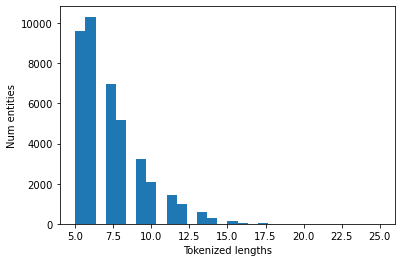

In [30]:
import matplotlib.pyplot as plt 

import numpy as np 

%matplotlib inline

# x = np.random.normal(size = 1000) 
x = lengths
plt.hist(x, bins=30) 

plt.ylabel('Num entities');
plt.xlabel('Tokenized lengths')

In [31]:
len(aliases_dict)

40943

In [32]:
def mapTriple(t, aliases_dict):
    out = triple2text(t)
    return out

In [33]:
for id in range(500):
    print(mapTriple(data['train'][id], aliases_dict))

['land reform NN 1', 'hypernym', 'reform NN 1']
['cover VB 1', 'derivationally related form', 'covering NN 2']
['phytology NN 1', 'derivationally related form', 'botanize VB 1']
['kamet NN 1', 'instance hypernym', 'mountain peak NN 1']
['question NN 1', 'derivationally related form', 'inquire VB 1']
['class arachnida NN 1', 'derivationally related form', 'spidery JJ 1']
['run up VB 2', 'hypernym', 'raise VB 2']
['empathy NN 1', 'hypernym', 'sympathy NN 2']
['pullout NN 1', 'hypernym', 'retreat NN 1']
['variation NN 9', 'derivationally related form', 'vary VB 2']
['genus equisetum NN 1', 'hypernym', 'fern genus NN 1']
['write VB 1', 'also see', 'write up VB 2']
['queen regnant NN 1', 'hypernym', 'female aristocrat NN 1']
['working dog NN 1', 'hypernym', 'domestic dog NN 1']
['charge NN 11', 'hypernym', 'request NN 2']
['primulaceae NN 1', 'member meronym', 'glaux NN 1']
['proteaceae NN 1', 'member meronym', 'green dinosaur NN 1']
['lodge VB 4', 'derivationally related form', 'accommodat

In [34]:
len(data['train'])

86835

In [35]:
out_folder = '/scratche/home/apoorv/transformer-kgc/data/wnrr_2'
splits = ['train', 'test', 'valid']

count = 0
for split in splits:
    fname = os.path.join(out_folder, split + '.txt')
    f = open(fname, 'w')
    triples = data[split]
    for t in triples:
        
        t = mapTriple(t, aliases_dict)
        # only save those that DO NOT start with m. or g.
        # we can do that since aim is KGQA not KGC
        head, relation, tail = t
        input = 'predict tail: {0} | {1}'.format(head, relation)
        output = '{}'.format(tail)
        f.write(input + '\t' + output + '\n')
        
        input = 'predict head: {0} | {1}'.format(tail, relation)
        output = '{}'.format(head)
        f.write(input + '\t' + output + '\n')
    f.close()

In [36]:
count

0

In [37]:
entity_names = set()
for key, value in aliases_dict.items():
#     if key.startswith('Q'):
    entity_names.add(value)
len(entity_names)

40943

In [38]:
# create entity_strings.txt which is needed in evaluation code
strings_file_name = 'entity_strings.txt'
f = open(os.path.join(out_folder, strings_file_name), 'w')
ents_uniq = entity_names
for e in ents_uniq:
    f.write(e + '\n')
f.close()

In [99]:
# webqsp qa 
# def readQALines(fname):
#     f = open(fname)
#     questions = []
#     for line in f:
#         line = line.strip().split('\t')
#         q = line[0]
#         lhs = q.split('[')[0]
#         rhs = q.split(']')[1]
#         only_question = lhs + 'NE' + rhs
#         only_question = normalizeEntity(only_question)
# #         q = q.replace('[', '')
# #         q = q.replace(']', '')
# #         q = normalizeEntity(q)
#         questions.append(only_question)
#     return questions
        
# def writeLines(lines, fname):
#     f = open(fname, 'w')
#     for line in lines:
#         f.write(line + '\n')


'what character did natalie portman play in star wars NE'

In [81]:
# fname = 'data/MetaQA/full_qa.txt'
# questions = readQALines(fname)
# questions = list(set(questions))

In [82]:
# fname = 'data/MetaQA/only_questions_text.txt'
# writeLines(questions, fname)

In [138]:
vocab_size = 30000
sp = spm.SentencePieceTrainer.train(input='data/fbwq_half/train.txt', 
                                    model_prefix='fbwq_with_pad', vocab_size=vocab_size, 
                                    pad_id=3,
#                                     character_coverage=1.0,
#                                user_defined_symbols=['predict',
#                                                     'head',
#                                                     'tail',
#                                                     '|'],
#                                     normalization_rule_name='identity',
                              )

In [139]:
# sp = spm.SentencePieceProcessor(model_file='data/sentencepiece/metaqa_with_pad.model')
sp = spm.SentencePieceProcessor(model_file='fbwq_with_pad.model')

In [38]:
# sp['Obama']

0

In [151]:
sp.decode(sp.encode('how old'))

'how old'

In [192]:
sp.encode('<pad>')

[5, 0, 12497, 0]

In [195]:
sp['</s>']

2

In [193]:
sp.id_to_piece(3)

'<pad>'

In [176]:
lengths = []
count = 0
for e in tqdm(ents_uniq):
    encoded = sp.encode(e)
    l = len(encoded)
    if l > 500:
        print(e,l)
        l = 20
        count += 1
    lengths.append(l)
count

100%|██████████| 1712213/1712213 [00:18<00:00, 91029.72it/s] 


0

Text(0.5, 0, 'Tokenized lengths')

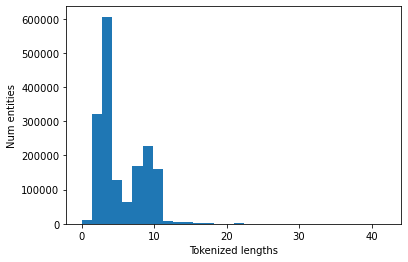

In [177]:
import matplotlib.pyplot as plt 

import numpy as np 

%matplotlib inline

# x = np.random.normal(size = 1000) 
x = lengths
plt.hist(x, bins=30) 

plt.ylabel('Num entities');
plt.xlabel('Tokenized lengths')

In [190]:
lengths = []
count = 0
for e in tqdm(relations):
    encoded = sp.encode(relation_map[e])
    l = len(encoded)
    if l > 10:
        print(relation_map[e])
        count +=1
    lengths.append(l)
count

100%|██████████| 1068/1068 [00:00<00:00, 41292.34it/s]

astronomical objects discovered
astronomical objects discovered reverse
sewage treatment plant
sewage treatment plant reverse
infidelity perpetrator reverse
substance abuse reverse
lifetime batting statistics reverse
sponsored by reverse
substance abuse problems reverse
appears in these fictional universes reverse
jurisdiction of office reverse
body this is a component of reverse
politicians in this party reverse
websites owned reverse
tropical cyclone season reverse
olympics hosted reverse
types of places of worship reverse
athletic performances reverse
mode of transportation reverse
appeared in tv episodes reverse
episodes appeared in reverse


21

Text(0.5, 0, 'Tokenized lengths')

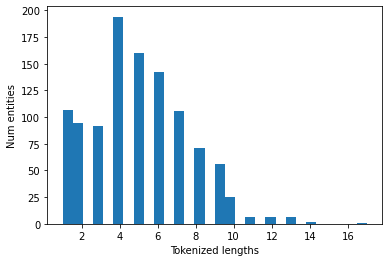

In [186]:
import matplotlib.pyplot as plt 

import numpy as np 

%matplotlib inline

# x = np.random.normal(size = 1000) 
x = lengths
plt.hist(x, bins=30) 

plt.ylabel('Num entities');
plt.xlabel('Tokenized lengths')

In [191]:
sp.encode('plays for')

[167, 10, 96]

In [104]:
len(uniq_ent_map)

1880592

In [143]:
def replaceEntities(line, aliases_dict):
    line = line.strip().split('\t')
    q = line[0]
    # sometimes no answer
    if len(line) > 1:
        answers= line[1].split('|')
    else:
        answers = []    
    lhs = q.split('[')[0]
    rhs = q.split(']')[1]
    head_id = q.split('[')[1].split(']')[0]
    if head_id in aliases_dict:
        head_text = aliases_dict[head_id]
    else:
        head_text = head_id
        print(head_text + ' not found')
    answers_text = []
    for a in answers:
        if a in aliases_dict:
            answers_text.append(aliases_dict[a])
        else:
            answers_text.append(a)
    answers_string = '|'.join(answers_text)
    
    out = '{lhs}[{head}]{rhs}\t{ans}'.format(
        lhs=lhs,
        rhs=rhs,
        head = head_text,
        ans = answers_string
    )
    return out
        
def readLines(fname):
    f = open(fname)
    lines = []
    for line in f:
        lines.append(line.rstrip())
    f.close()
    return lines

def writeLines(lines, fname):
    f = open(fname, 'w')
    for line in lines:
        f.write(line + '\n')
    f.close()

In [137]:
# need to make qa data as well, since entity aliases need to be used
# and not just entity ids as answers
fname = '/scratche/home/apoorv/EmbedKGQA/data/QA_data/WebQuestionsSP/qa_test_webqsp_fixed.txt'
questions = readLines(fname)


In [138]:
questions[1]

'what did james k polk do before he was president [m.042f1]\tm.02_bcst|m.04x_n9q|m.0cgqx'

In [144]:
lines_with_entities = [replaceEntities(q, uniq_ent_map) for q in questions]

m.02vkmj9 not found


In [145]:
len(lines_with_entities)

1639

In [146]:
lines_with_entities[:10]

['what does jamaican people speak [Jamaica 1]\tJamaican English|Jamaican Creole English Langua|Jamaican English',
 'what did james k polk do before he was president [James K. Polk]\tUnited States Representative|Governor of Tennessee|Speaker of the United States H',
 'who plays ken barlow in coronation street [Coronation Street]\tWilliam Roache',
 'where is jamarcus russell from [JaMarcus Russell]\tMobile 0',
 'where was george washington carver from [George Washington Carver]\tDiamond 8',
 'what else did ben franklin invent [Benjamin Franklin]\tLightning rod|Bifocals|Glass harmonica|Franklin stove',
 'who was richard nixon married to [Richard Nixon]\tPat Nixon',
 'who is governor of ohio 2011 [Ohio 2]\tJohn Kasich|Return J. Meigs, Jr.|Ted Strickland',
 'who was vice president after kennedy died [John F. Kennedy 0]\tLyndon B. Johnson 1',
 'where is the fukushima daiichi nuclear plant located [Fukushima Daiichi Nuclear Powe]\tJapan 1|Okuma']

In [148]:
fname = 'data/fbwq_half/qa_valid_1hop.txt'
writeLines(lines_with_entities, fname)